In [26]:
import numpy as np
from matplotlib import pyplot as plt
from math import pi as pi
from scipy.spatial.transform import Rotation as R
import tensorflow
from tensorflow.keras import mixed_precision


policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)

size = 16


# Probably need to rewrite this but use v0 as the random variable
def get_rand_tetra_loc(num_tetra, v0, v1, v2, v3, Flip = False):
   
    trans = np.zeros((3, num_tetra))
    trans[0,:] = np.random.uniform(-5.,5., num_tetra)
    trans[1,:] = np.random.uniform(-5.,5., num_tetra)
    trans[2,:] = np.random.uniform(-5.,5., num_tetra)

    rot_arr = R.random(num = num_tetra).as_matrix()
   
    if Flip == True:
        #flip_idx = np.random.choice(num_tetra, int(num_tetra/2), replace=False)
        v0_flip, v1_flip, v2_flip, v3_flip = -v0.copy(), -v1.copy(), -v2.copy(), -v3.copy()
       
    tetra = np.zeros((4,3,num_tetra))
    for i in range(num_tetra):
        if Flip == True:
            tetra[0,:,i] = np.dot(rot_arr[i,:,:], v0_flip) + trans[:,i]
            tetra[1,:,i] = np.dot(rot_arr[i,:,:], v1_flip) + trans[:,i]
            tetra[2,:,i] = np.dot(rot_arr[i,:,:], v2_flip) + trans[:,i]
            tetra[3,:,i] = np.dot(rot_arr[i,:,:], v3_flip) + trans[:,i]

        else:
            tetra[0,:,i] = np.dot(rot_arr[i,:,:], v0) + trans[:,i]
            tetra[1,:,i] = np.dot(rot_arr[i,:,:], v1) + trans[:,i]
            tetra[2,:,i] = np.dot(rot_arr[i,:,:], v2) + trans[:,i]
            tetra[3,:,i] = np.dot(rot_arr[i,:,:], v3) + trans[:,i]
               
       
    return tetra



num_left_tet = 3
num_right_tet = 1
v0 = np.array([8,0,0])
v1 = np.array([0,4,0])
v2 = np.array([0,0,2])
v3 = np.array([0,0,0])


def get_rand_tet_excess(num_left_tet, num_right_tet, v0, v1, v2, v3, master_flip = False):
    n_tet = num_left_tet + num_right_tet
    dat = np.zeros((4,3,n_tet))
    if master_flip == False:
        dat[:,:,:num_left_tet] = get_rand_tetra_loc(num_left_tet, v0, v1, v2, v3, Flip = False)
        dat[:,:,num_left_tet:] = get_rand_tetra_loc(num_right_tet, v0, v1, v2, v3, Flip = True)
    else:
        dat[:,:,:num_left_tet] = get_rand_tetra_loc(num_left_tet, v0, v1, v2, v3, Flip = True)
        dat[:,:,num_left_tet:] = get_rand_tetra_loc(num_right_tet, v0, v1, v2, v3, Flip = False)      
    return dat



def get_ran_field(tetra):
   
    num_tetra = np.shape(tetra)[2]
    verts = np.zeros((4 * num_tetra, 3))
    for v in range(4):
        for n in range(num_tetra):
            verts[4*n+v,:] = tetra[v,:,n]

    npix = size
    mn = -size
    mx = size
    pix_sz = (mx - mn) / npix

    grid = np.zeros((size,size,size))      
    for v in range(4 * num_tetra):
        x = verts[v,0]
        y = verts[v,1]
        z = verts[v,2]
        xpix = int((x - mn) / pix_sz )
        ypix = int((y - mn) / pix_sz )
        zpix = int((z - mn) / pix_sz )
        grid[xpix, ypix, zpix] += 1
    return grid


test = get_ran_field(get_rand_tet_excess(num_left_tet, num_right_tet, v0, v1, v2, v3)) 


from scatter import Scatter3D

J = 4
L = 4
M = 16
slant1 = 4./L
slant2 = 2./L

ntrain = 1000
nvalid = 100

nbatch_train = 20
nbatch_valid = 10
batch_size_train = int(ntrain / nbatch_train)
batch_size_valid = int(nvalid / nbatch_valid)


xtrain, xvalid = np.zeros((batch_size_train,size,size,size)), np.zeros((batch_size_valid,size,size,size))


inp_train = (size, size, size)
inp_valid = inp_train

Scat = Scatter3D(J,L,M,slant1, slant2)
filter_bank = Scat.filter_bank()



x = tensorflow.ones((10,16,16,16))
'''

phi = filter_bank['phi']
psi = filter_bank['psi']
max_order = 3
coeffs = Scat.compute_coefs_no_pad_extend(x, phi, psi, max_order, out_type = 'array')
print (np.shape(coeffs))

compressed_shape = np.shape(coeffs)[2]


Xtrain, Xtrain_flip = np.zeros((ntrain,compressed_shape)), np.zeros((ntrain,compressed_shape)) 
for i in range(nbatch_train):
    print (i)
    for j in range(batch_size_train):
        xtrain[j,:,:,:] = get_ran_field(get_rand_tet_excess(num_left_tet, num_right_tet, v0, v1, v2, v3))
    xtrain_flip = xtrain[:,::-1,:,:]
    Xtrain[i*batch_size_train:(i+1)*batch_size_train] =\
    Scat.compute_coefs_no_pad_extend(xtrain, phi, psi, max_order, out_type = 'array')[:,0,:,0,0]
    Xtrain_flip[i*batch_size_train:(i+1)*batch_size_train] =\
    Scat.compute_coefs_no_pad_extend(xtrain_flip, phi, psi, max_order, out_type = 'array')[:,0,:,0,0]
    
    
Xvalid, Xvalid_flip = np.zeros((nvalid,compressed_shape)), np.zeros((nvalid,compressed_shape)) 
for i in range(nbatch_valid):
    print (i)
    for j in range(batch_size_valid):
        xvalid[j,:,:,:] = get_ran_field(get_rand_tet_excess(num_left_tet, num_right_tet, v0, v1, v2, v3))
    xvalid_flip = xvalid[:,::-1,:,:]
    Xvalid[i*batch_size_valid:(i+1)*batch_size_valid] =\
    Scat.compute_coefs_no_pad_extend(xvalid, phi, psi, max_order, out_type = 'array')[:,0,:,0,0]
    Xvalid_flip[i*batch_size_valid:(i+1)*batch_size_valid] =\
    Scat.compute_coefs_no_pad_extend(xvalid_flip, phi, psi, max_order, out_type = 'array')[:,0,:,0,0]
    
'''

"\n\nphi = filter_bank['phi']\npsi = filter_bank['psi']\nmax_order = 3\ncoeffs = Scat.compute_coefs_no_pad_extend(x, phi, psi, max_order, out_type = 'array')\nprint (np.shape(coeffs))\n\ncompressed_shape = np.shape(coeffs)[2]\n\n\nXtrain, Xtrain_flip = np.zeros((ntrain,compressed_shape)), np.zeros((ntrain,compressed_shape)) \nfor i in range(nbatch_train):\n    print (i)\n    for j in range(batch_size_train):\n        xtrain[j,:,:,:] = get_ran_field(get_rand_tet_excess(num_left_tet, num_right_tet, v0, v1, v2, v3))\n    xtrain_flip = xtrain[:,::-1,:,:]\n    Xtrain[i*batch_size_train:(i+1)*batch_size_train] =    Scat.compute_coefs_no_pad_extend(xtrain, phi, psi, max_order, out_type = 'array')[:,0,:,0,0]\n    Xtrain_flip[i*batch_size_train:(i+1)*batch_size_train] =    Scat.compute_coefs_no_pad_extend(xtrain_flip, phi, psi, max_order, out_type = 'array')[:,0,:,0,0]\n    \n    \nXvalid, Xvalid_flip = np.zeros((nvalid,compressed_shape)), np.zeros((nvalid,compressed_shape)) \nfor i in range(nb

In [27]:
dr = '/Users/taylor.4264/test/parity/scatter/data/'
'''
dr = '/Users/taylor.4264/test/parity/scatter/data/' 
np.save(dr + 'Xtrain.npy', Xtrain)
np.save(dr + 'Xtrain_flip.npy', Xtrain_flip)

np.save(dr + 'Xvalid.npy', Xvalid)
np.save(dr + 'Xvalid_flip.npy', Xvalid_flip)
'''

Xtrain = np.load(dr + 'Xtrain.npy')
Xtrain_flip = np.load(dr + 'Xtrain_flip.npy')
Xvalid = np.load(dr + 'Xvalid.npy')
Xvalid_flip = np.load(dr + 'Xvalid_flip.npy')

# compression

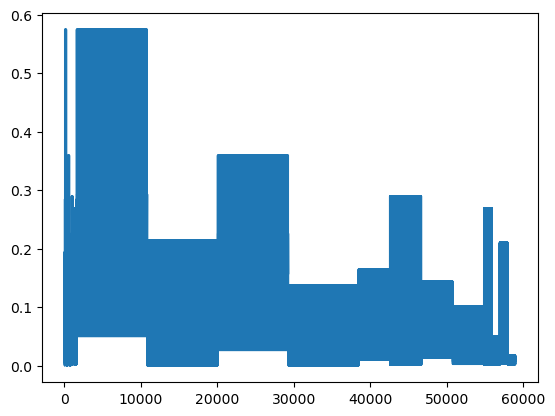

In [28]:
plt.plot((np.abs((Xtrain[3] - Xtrain_flip[3])) / Xtrain[3])[:] )

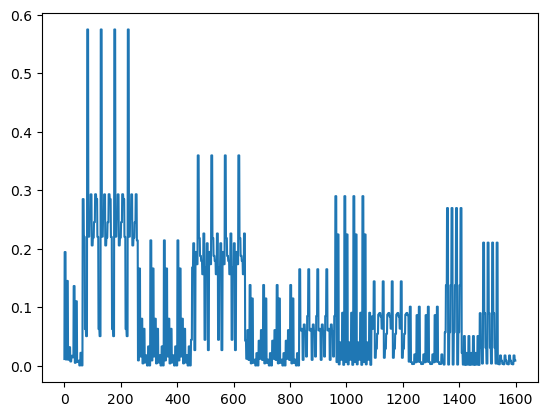

In [29]:
plt.plot((np.abs((Xtrain[3] - Xtrain_flip[3])) / Xtrain[3])[:1600] )

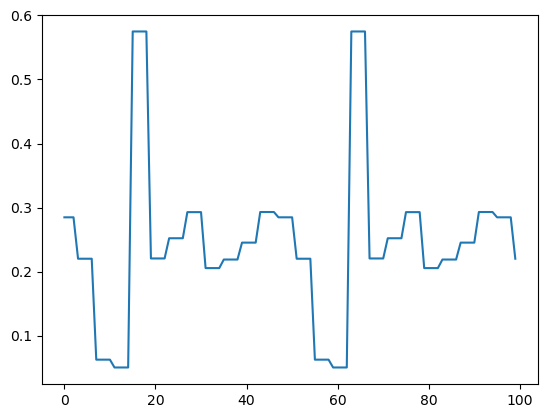

In [30]:
plt.plot((np.abs((Xtrain[3] - Xtrain_flip[3])) / Xtrain[3])[1650:1750] )

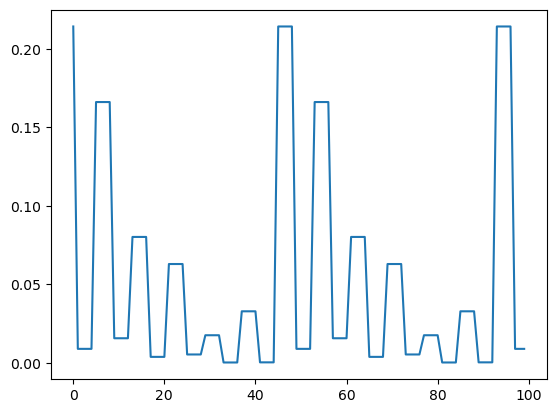

In [31]:
plt.plot((np.abs((Xtrain[3] - Xtrain_flip[3])) / Xtrain[3])[12500:12600] )

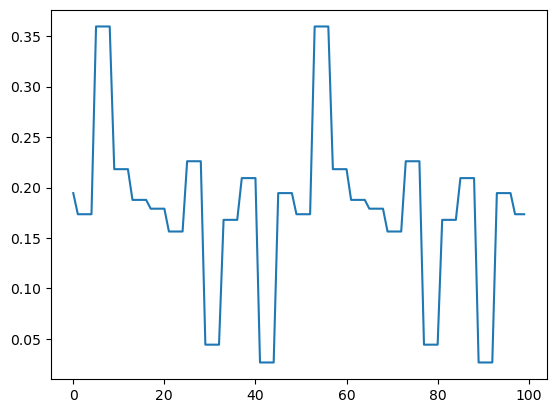

In [32]:
plt.plot((np.abs((Xtrain[3] - Xtrain_flip[3])) / Xtrain[3])[22500:22600] )

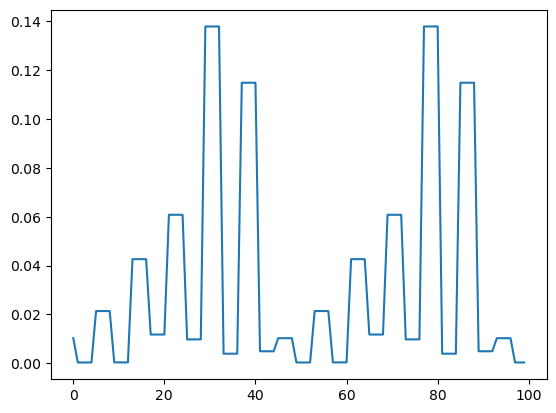

In [33]:
plt.plot((np.abs((Xtrain[3] - Xtrain_flip[3])) / Xtrain[3])[32500:32600] )

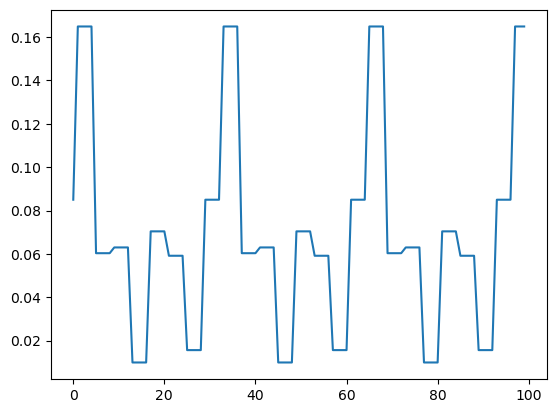

In [34]:
plt.plot((np.abs((Xtrain[3] - Xtrain_flip[3])) / Xtrain[3])[40000:40100] )

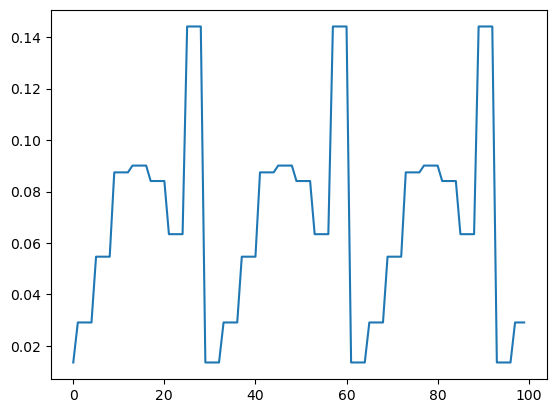

In [35]:
plt.plot((np.abs((Xtrain[3] - Xtrain_flip[3])) / Xtrain[3])[50000:50100] )

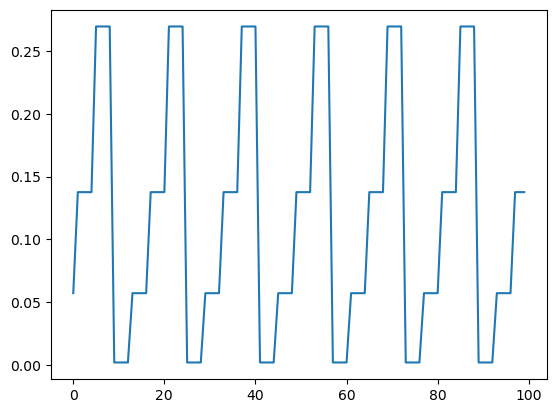

In [36]:
plt.plot((np.abs((Xtrain[3] - Xtrain_flip[3])) / Xtrain[3])[55000:55100] )

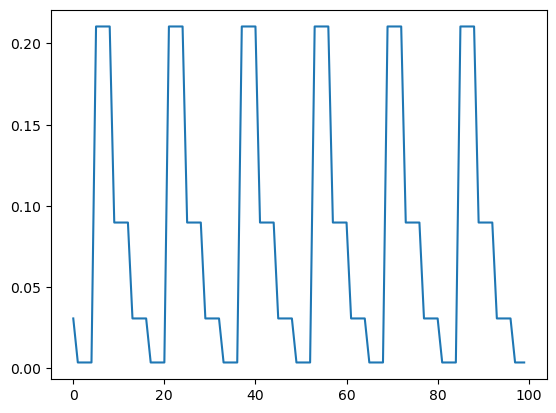

In [37]:
plt.plot((np.abs((Xtrain[3] - Xtrain_flip[3])) / Xtrain[3])[57000:57100] )

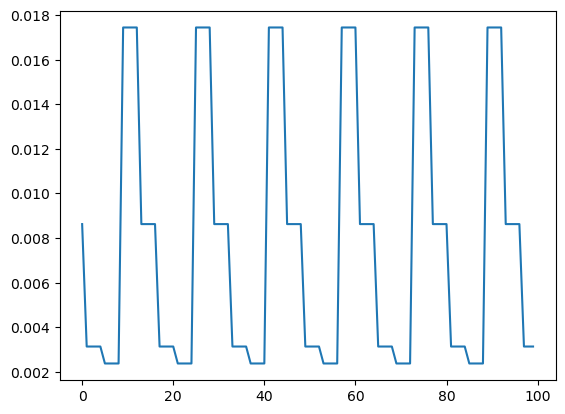

In [38]:
plt.plot((np.abs((Xtrain[3] - Xtrain_flip[3])) / Xtrain[3])[58000:58100] )

In [39]:
Xtrain_new = np.zeros((ntrain, 2500))
Xtrain_new_flip = np.zeros((ntrain, 2500))
Xvalid_new = np.zeros((nvalid, 2500))
Xvalid_new_flip = np.zeros((nvalid, 2500))

In [40]:



Xtrain_new[:,:1600]     = Xtrain[:,:1600]
Xtrain_new[:,1600:1700] = Xtrain[:,1650:1750]
Xtrain_new[:,1700:1800] = Xtrain[:,12500:12600]
Xtrain_new[:,1800:1900] = Xtrain[:,22500:22600]
Xtrain_new[:,1900:2000] = Xtrain[:,32500:32600]
Xtrain_new[:,2000:2100] = Xtrain[:,40000:40100]
Xtrain_new[:,2100:2200] = Xtrain[:,50000:50100] 
Xtrain_new[:,2200:2300] = Xtrain[:,55000:55100]
Xtrain_new[:,2300:2400] = Xtrain[:,57000:57100]
Xtrain_new[:,2400:2500] = Xtrain[:,58000:58100]



Xtrain_new_flip[:,:1600]     = Xtrain_flip[:,:1600]
Xtrain_new_flip[:,1600:1700] = Xtrain_flip[:,1650:1750]
Xtrain_new_flip[:,1700:1800] = Xtrain_flip[:,12500:12600]
Xtrain_new_flip[:,1800:1900] = Xtrain_flip[:,22500:22600]
Xtrain_new_flip[:,1900:2000] = Xtrain_flip[:,32500:32600]
Xtrain_new_flip[:,2000:2100] = Xtrain_flip[:,40000:40100]
Xtrain_new_flip[:,2100:2200] = Xtrain_flip[:,50000:50100] 
Xtrain_new_flip[:,2200:2300] = Xtrain_flip[:,55000:55100]
Xtrain_new_flip[:,2300:2400] = Xtrain_flip[:,57000:57100]
Xtrain_new_flip[:,2400:2500] = Xtrain_flip[:,58000:58100]



Xvalid_new[:,:1600]     = Xvalid[:,:1600]
Xvalid_new[:,1600:1700] = Xvalid[:,1650:1750]
Xvalid_new[:,1700:1800] = Xvalid[:,12500:12600]
Xvalid_new[:,1800:1900] = Xvalid[:,22500:22600]
Xvalid_new[:,1900:2000] = Xvalid[:,32500:32600]
Xvalid_new[:,2000:2100] = Xvalid[:,40000:40100]
Xvalid_new[:,2100:2200] = Xvalid[:,50000:50100] 
Xvalid_new[:,2200:2300] = Xvalid[:,55000:55100]
Xvalid_new[:,2300:2400] = Xvalid[:,57000:57100]
Xvalid_new[:,2400:2500] = Xvalid[:,58000:58100]



Xvalid_new_flip[:,:1600]     = Xvalid_flip[:,:1600]
Xvalid_new_flip[:,1600:1700] = Xvalid_flip[:,1650:1750]
Xvalid_new_flip[:,1700:1800] = Xvalid_flip[:,12500:12600]
Xvalid_new_flip[:,1800:1900] = Xvalid_flip[:,22500:22600]
Xvalid_new_flip[:,1900:2000] = Xvalid_flip[:,32500:32600]
Xvalid_new_flip[:,2000:2100] = Xvalid_flip[:,40000:40100]
Xvalid_new_flip[:,2100:2200] = Xvalid_flip[:,50000:50100] 
Xvalid_new_flip[:,2200:2300] = Xvalid_flip[:,55000:55100]
Xvalid_new_flip[:,2300:2400] = Xvalid_flip[:,57000:57100]
Xvalid_new_flip[:,2400:2500] = Xvalid_flip[:,58000:58100]




# Done with the compression

In [41]:
s1 = np.shape(Xtrain_new)[1]
from tensorflow.keras.layers import Dense, Input, Subtract
from keras.models import Model

A1 = Input(shape=(s1), name='input layer 1')
B1 = Input(shape=(s1), name='input layer 2')


d1 = Dense(10, activation = 'relu')
A2 = d1(A1)
B2 = d1(B1)


d2 = Dense(10, activation = 'relu')
A4 = d2(A2)
B4 = d2(B2)



output = Dense(1, activation = 'linear', name = 'Output')
A6 =  output(A4)
B6 =  output(B4)  


out = Subtract()([A6,B6])

merged3 = Model(inputs=[A1, B1],outputs=[out])

In [42]:
class CustomLoss(tensorflow.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):        
        return - tensorflow.math.divide_no_nan(tensorflow.math.reduce_mean(y_pred), tensorflow.math.reduce_std(y_pred))

In [43]:
ytrain = np.zeros(np.shape(Xtrain_new)[0])
yvalid = np.zeros(np.shape(Xvalid_new)[0])



adamOpti = tensorflow.keras.optimizers.Adam (learning_rate = 0.001)
merged3.compile(optimizer = adamOpti, loss = CustomLoss())

history = merged3.fit(x = [Xtrain_new, Xtrain_new_flip], y = ytrain, \
                    validation_data=([Xvalid_new, Xvalid_new_flip], yvalid), epochs = 100, batch_size = 32)

Epoch 1/100
32/32 [==============================] - 0s 3ms/step - loss: -0.0801 - val_loss: -0.1586
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: -0.1000 - val_loss: -0.1663
Epoch 3/100
32/32 [==============================] - 0s 1ms/step - loss: -0.1134 - val_loss: -0.1827
Epoch 4/100
32/32 [==============================] - 0s 1ms/step - loss: -0.1077 - val_loss: -0.2075
Epoch 5/100
32/32 [==============================] - 0s 1ms/step - loss: -0.1168 - val_loss: -0.2047
Epoch 6/100
32/32 [==============================] - 0s 1ms/step - loss: -0.0890 - val_loss: -0.1967
Epoch 7/100
32/32 [==============================] - 0s 1ms/step - loss: -0.1120 - val_loss: -0.1962
Epoch 8/100
32/32 [==============================] - 0s 1ms/step - loss: -0.1171 - val_loss: -0.2040
Epoch 9/100
32/32 [==============================] - 0s 1ms/step - loss: -0.1150 - val_loss: -0.2011
Epoch 10/100
32/32 [==============================] - 0s 1ms/step - loss: -0.1206 - val_los

32/32 [==============================] - 0s 1ms/step - loss: -0.1229 - val_loss: -0.1456
Epoch 82/100
32/32 [==============================] - 0s 1ms/step - loss: -0.1227 - val_loss: -0.1400
Epoch 83/100
32/32 [==============================] - 0s 1ms/step - loss: -0.1214 - val_loss: -0.1438
Epoch 84/100
32/32 [==============================] - 0s 1ms/step - loss: -0.1173 - val_loss: -0.1444
Epoch 85/100
32/32 [==============================] - 0s 1ms/step - loss: -0.1199 - val_loss: -0.1258
Epoch 86/100
32/32 [==============================] - 0s 1ms/step - loss: -0.1268 - val_loss: -0.0986
Epoch 87/100
32/32 [==============================] - 0s 1ms/step - loss: -0.1276 - val_loss: -0.1392
Epoch 88/100
32/32 [==============================] - 0s 1ms/step - loss: -0.1216 - val_loss: -0.1366
Epoch 89/100
32/32 [==============================] - 0s 1ms/step - loss: -0.1296 - val_loss: -0.1265
Epoch 90/100
32/32 [==============================] - 0s 1ms/step - loss: -0.1235 - val_loss: -